In [ ]:
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import numpy as np
import pandas as pd 
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPool1D , MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
def display_audio(aud_name):
  path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/Crema/'+aud_name
  x, sr = librosa.load(path)
  ipd.display(ipd.Audio(x, rate=sr))
  plt.figure(figsize=(14, 5))
  librosa.display.waveplot(x, sr=sr)
  plt.show()

In [ ]:
def extracting_mel_spectrogram(aud_name):
  path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/Crema/'+aud_name
  scale, sr = librosa.load(path)
  mel_spectrogram = librosa.feature.melspectrogram(scale, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
  mel_spectrogram.shape
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  log_mel_spectrogram.shape
  plt.figure(figsize=(14,5 ))
  librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sr)
  plt.colorbar(format="%+2.f")
  plt.show()

 Sad 


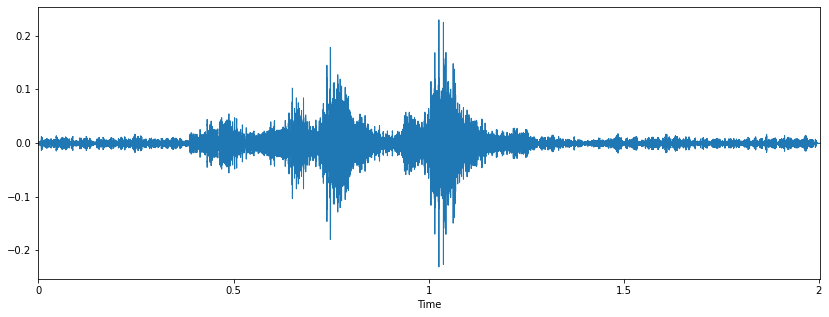



 Angry 


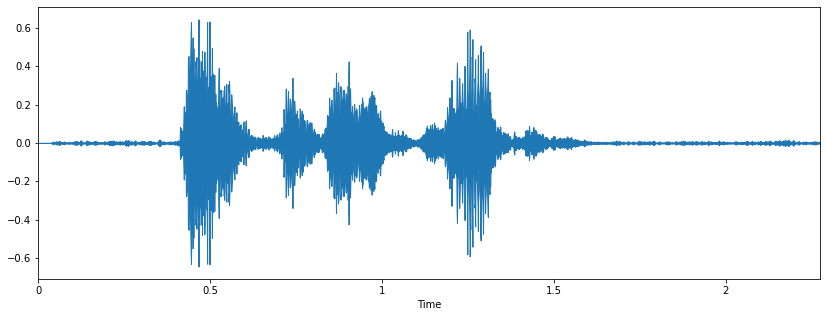



 Disgust 


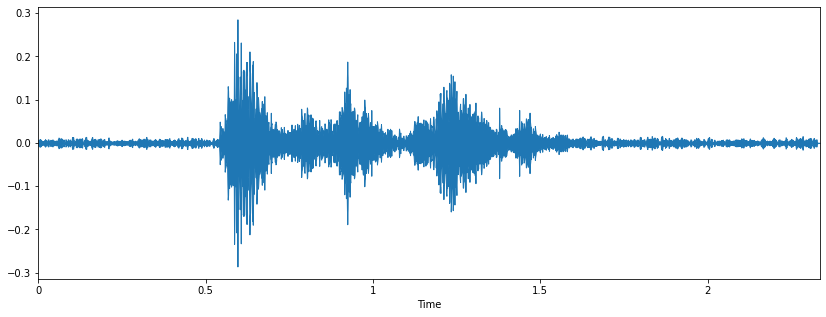



 Fear 


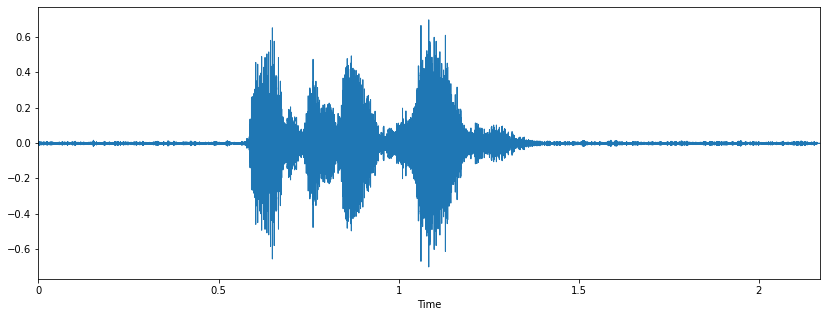



 Happy 


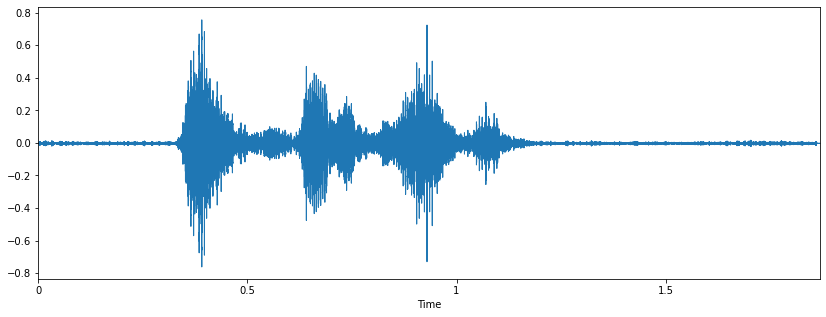



 Neutral 


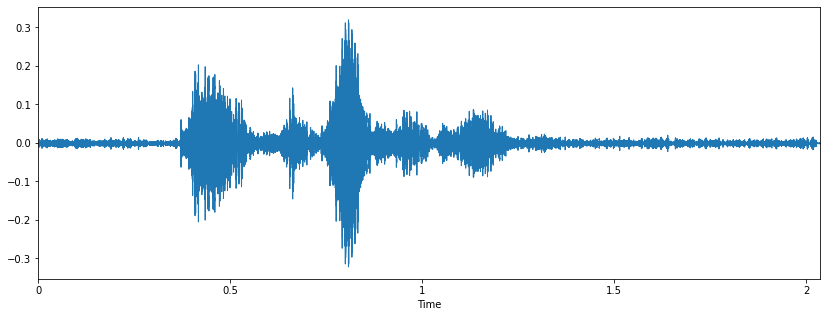

In [ ]:
# sad
print(" Sad ")
display_audio('1001_DFA_SAD_XX.wav')
# angry
print("\n\n Angry ")
display_audio('1001_DFA_ANG_XX.wav')
# disgust
print("\n\n Disgust ")
display_audio('1001_DFA_DIS_XX.wav')
# fear
print("\n\n Fear ")
display_audio('1001_DFA_FEA_XX.wav')
# happy
print("\n\n Happy ")
display_audio('1001_DFA_HAP_XX.wav')
# neutral
print("\n\n Neutral ")
display_audio('1001_DFA_NEU_XX.wav')


 Sad 


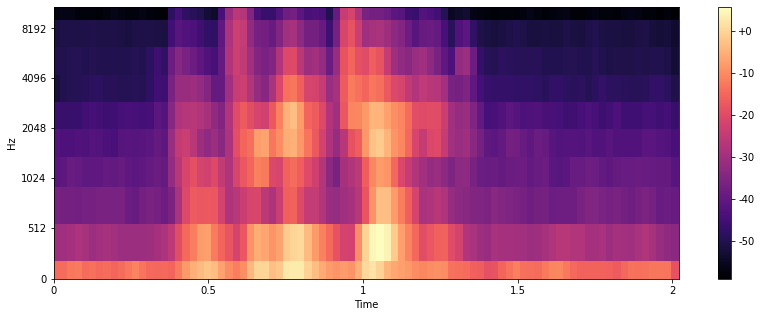



 Angry 


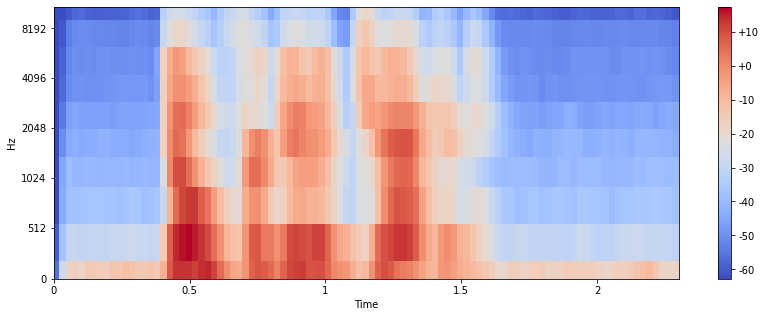



 Disgust 


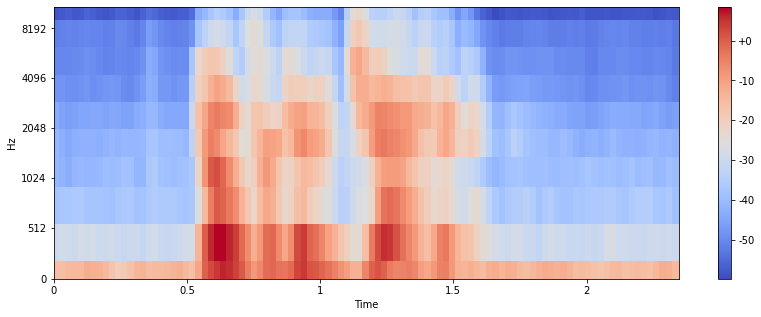



 Fear 


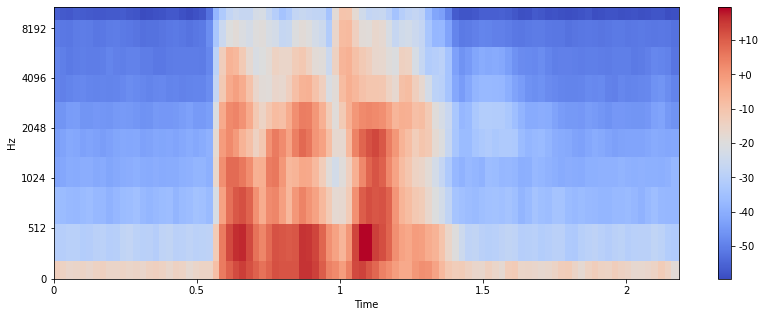



 Happy 


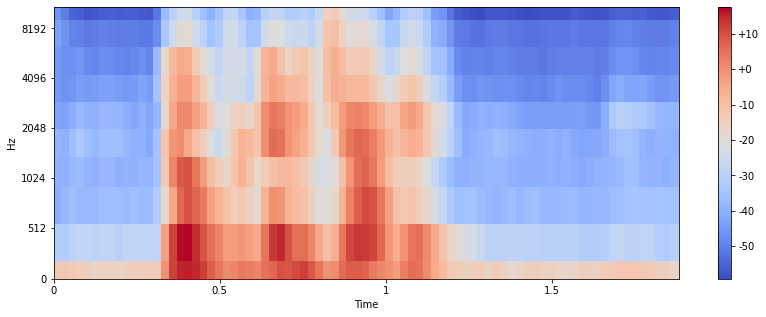



 Neutral 


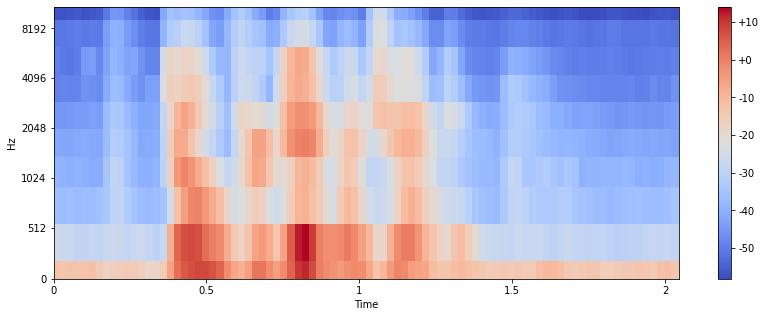

In [ ]:
# sad
print(" Sad ")
extracting_mel_spectrogram('1001_DFA_SAD_XX.wav')
# angry
print("\n\n Angry ")
extracting_mel_spectrogram('1001_DFA_ANG_XX.wav')
# disgust
print("\n\n Disgust ")
extracting_mel_spectrogram('1001_DFA_DIS_XX.wav')
# fear
print("\n\n Fear ")
extracting_mel_spectrogram('1001_DFA_FEA_XX.wav')
# happy
print("\n\n Happy ")
extracting_mel_spectrogram('1001_DFA_HAP_XX.wav')
# neutral
print("\n\n Neutral ")
extracting_mel_spectrogram('1001_DFA_NEU_XX.wav')

In [ ]:
def crema_data():
  crema = "/content/drive/MyDrive/Colab Notebooks/pattern/lab3/Crema/"
  # labels of different classes
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  crema_emotion = []
  crema_path = []
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    # add label
    crema_emotion.append(emotion_crema[emotion])
    # add path of audio
    crema_path.append(crema+i)

  # create dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  return df_crema

In [ ]:
def audio_data(df):
  result = []
  labels = np.empty((0,1))
  i=1
  j = 1
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("process",i)
    i+=1
    x, sr = librosa.load(path)
    result.append(x)
    labels = np.vstack((labels ,emotion))
    if i%1000 == 0:
      df_crema = pd.DataFrame(result)
      df_crema = df_crema.T.fillna(df_crema.mean(axis=1)).T
      df_crema = df_crema.iloc[:, :50000]
      data = df_crema.to_numpy()
      save_data(data,labels,'secondmodel'+str(j),'secondlabels'+str(j))
      j+=1
      result = []
      labels = np.empty((0,1))

  
  df_crema = pd.DataFrame(result)
  df_crema = df_crema.T.fillna(df_crema.mean(axis=1)).T
  df_crema = df_crema.iloc[:, :50000]
  data = df_crema.to_numpy()
  save_data(data,labels,'secondmodel'+str(j),'secondlabels'+str(j))
  print("ended")


In [ ]:
def get_mel_spectrogram(df):
  training = []
  for row in df:
    mel_spectrogram = librosa.feature.melspectrogram(row)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
    print(log_mel_spectrogram.shape)
    log_mel_spectrogram = log_mel_spectrogram.reshape((-1,))
    training.append(log_mel_spectrogram)
  return np.array(training)

In [ ]:
# encode labels to numeric values
def encode_labels():
  # Build new lists of encoding labels
  y_labels_encoded = {}
  for i, label in enumerate(lb.classes_):
      y_labels_encoded[i] = label
  return y_labels_encoded

In [ ]:
# convert string labels to numeric lables
def convert_pred(y_test_preds,encoded):
  y_test_preds_labels =[]
  # Go through each prediction and append to new list
  for e in range(len(y_test_preds)):
      y_test_preds_labels.append(encoded[y_test_preds[e]])

  return y_test_preds_labels

In [ ]:
# load preprocessed data
def load_saved_data(path):
  data = np.load(path)
  return data

In [ ]:
def save_data(result,labels,f1_name,f2_name):
  path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/'+f1_name+'.npy'
  np.save(path,result)
  path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/'+f2_name+'.npy'
  np.save(path,labels)

In [ ]:
def create_model():
  cnn_model = Sequential()
  # 1 stride
  cnn_model.add(Conv2D(512, (5,5),padding='same',input_shape=(128,98, 1), activation='relu'))
  # max pool
  cnn_model.add(MaxPool2D( pool_size=5))

  # 2 strides
  cnn_model.add(Conv2D(128, (5,5),padding='same',activation='relu'))
  cnn_model.add(Conv2D(128, (5,5),padding='same',activation='relu'))

  # max pool
  cnn_model.add(MaxPool2D( pool_size=5,padding='same'))

  # dropout
  cnn_model.add(Dropout(0.5))

  # flatten to add fully connected layer
  cnn_model.add(Flatten())

  # fully connected layer
  cnn_model.add(Dense(512, activation ='relu'))
  # dropout
  cnn_model.add(Dropout(0.5))

   # fully connected layer
  cnn_model.add(Dense(64, activation ='relu'))
  # output layer
  cnn_model.add(Dense(6, activation='softmax')) 
  return cnn_model



In [ ]:
# load data path
df = crema_data()
audio_data(df)
print("the end")


Streaming output truncated to the last 5000 lines.
process 2445
process 2446
process 2447
process 2448
process 2449
process 2450
process 2451
process 2452
process 2453
process 2454
process 2455
process 2456
process 2457
process 2458
process 2459
process 2460
process 2461
process 2462
process 2463
process 2464
process 2465
process 2466
process 2467
process 2468
process 2469
process 2470
process 2471
process 2472
process 2473
process 2474
process 2475
process 2476
process 2477
process 2478
process 2479
process 2480
process 2481
process 2482
process 2483
process 2484
process 2485
process 2486
process 2487
process 2488
process 2489
process 2490
process 2491
process 2492
process 2493
process 2494
process 2495
process 2496
process 2497
process 2498
process 2499
process 2500
process 2501
process 2502
process 2503
process 2504
process 2505
process 2506
process 2507
process 2508
process 2509
process 2510
process 2511
process 2512
process 2513
process 2514
process 2515
process 2516
process 2517


"\ndata = result.to_numpy()\nsave_data(data,labels,'secondmodel','secondlabels')\nprint('data is saved')\ndel result,data,labels\n\nresult = get_mel_spectrogram(data)\nprint(result.shape)\nprint(labels.shape)\n\n#\n"

In [ ]:
# process data in batches becaues of RAM limit
path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/secondmodel8.npy'
data = load_saved_data(path)

path='/content/drive/MyDrive/Colab Notebooks/pattern/lab3/processed/secondmodel8.npy'
res =  get_mel_spectrogram(data)
print(res.shape)
#np.save(path,res)

print("finished")


(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)
(128, 98)


In [ ]:
# loat and concatenate data 
result = np.empty((0,12544))
labels = np.empty((0,1))
for i in range(1,9):
  path1 = f'/content/drive/MyDrive/Colab Notebooks/pattern/lab3/processed/secondmodel{str(i)}.npy'
  path2 = f'/content/drive/MyDrive/Colab Notebooks/pattern/lab3/secondlabels{str(i)}.npy'
  data = load_saved_data(path1)
  loaded_labels = load_saved_data(path2)
  result = np.vstack((result,data))
  labels = np.vstack((labels,loaded_labels))

print("result",result.shape)
print("labels",labels.shape)


result (7442, 12544)
labels (7442, 1)


In [ ]:
lb = LabelEncoder()
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(result, labels,test_size=0.3, random_state=1)

# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1)
print(x_train.shape)
# expand dimensions
x_traincnn = x_train.reshape(-1, 128, 98, 1)
x_valcnn = x_val.reshape(-1, 128, 98, 1)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))

(4948, 12544)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


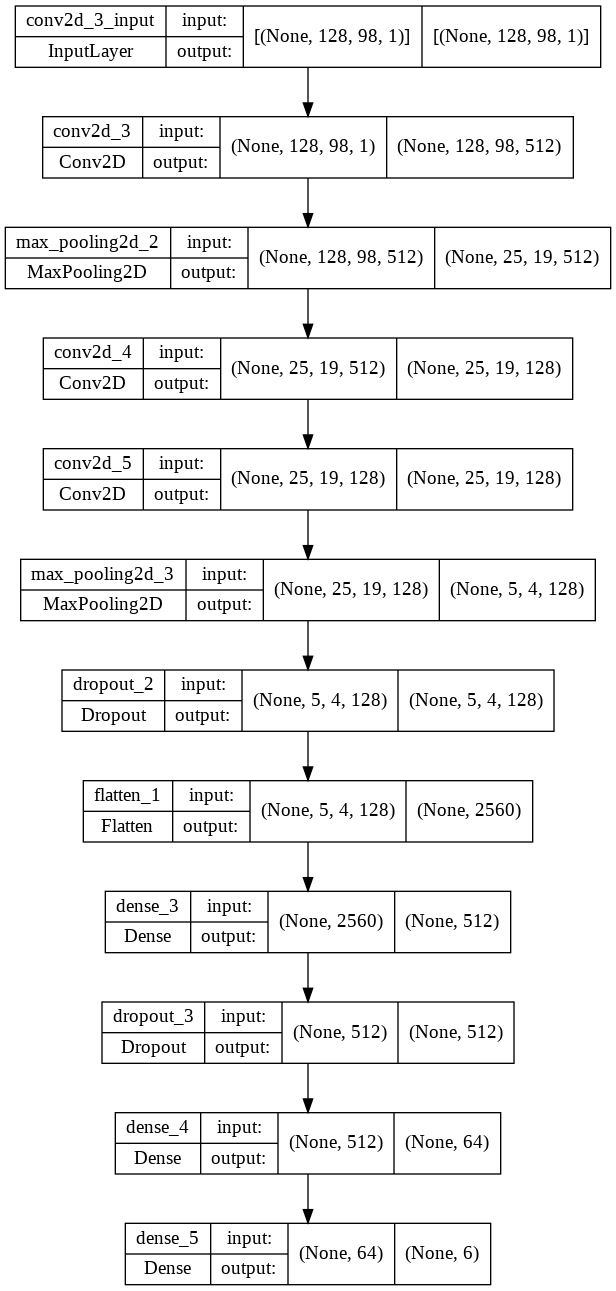

In [ ]:
# create model
model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

# Save an image of the model's architecture to a file
plot_model(model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train model
cnn_results = model.fit(x_traincnn, y_train_lb,
                epochs = 50,
                verbose = 1,
                validation_data = (x_valcnn, y_val_lb))


Epoch 1/50
155/155 [==============================] - 13s 78ms/step - loss: 1.9575 - accuracy: 0.3155 - val_loss: 1.4597 - val_accuracy: 0.4253
Epoch 2/50
155/155 [==============================] - 12s 77ms/step - loss: 1.5026 - accuracy: 0.3882 - val_loss: 1.4205 - val_accuracy: 0.4483
Epoch 3/50
155/155 [==============================] - 12s 77ms/step - loss: 1.4579 - accuracy: 0.4091 - val_loss: 1.3885 - val_accuracy: 0.4598
Epoch 4/50
155/155 [==============================] - 12s 76ms/step - loss: 1.4135 - accuracy: 0.4287 - val_loss: 1.3682 - val_accuracy: 0.4253
Epoch 5/50
155/155 [==============================] - 12s 76ms/step - loss: 1.3955 - accuracy: 0.4400 - val_loss: 1.4335 - val_accuracy: 0.4023
Epoch 6/50
155/155 [==============================] - 12s 77ms/step - loss: 1.3817 - accuracy: 0.4497 - val_loss: 1.4202 - val_accuracy: 0.4023
Epoch 7/50
155/155 [==============================] - 12s 77ms/step - loss: 1.3775 - accuracy: 0.4513 - val_loss: 1.3967 - val_accuracy:

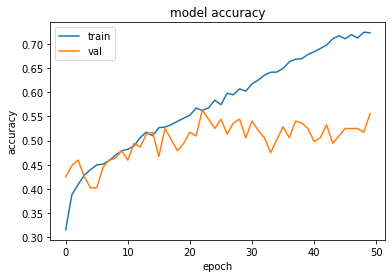

In [ ]:
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

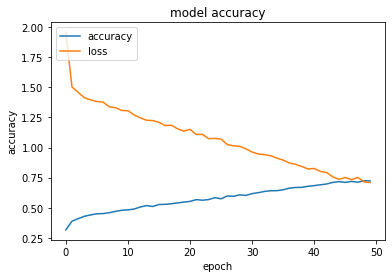

In [ ]:
# Plot model accuracy and loss over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [ ]:
# train accuracy
score = model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.895917534828186


In [ ]:
# evaluate test set

# expand dimensions
x_testcnn = x_test.reshape(-1, 128, 98, 1)

# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Testing Accuracy:  0.5096282958984375


In [ ]:
# report and confusion matrix

#Get predictions from model
y_test_predictions = np.argmax(model.predict(x_testcnn),axis=1)
#Build new lists of encoding labels
y_labels_encoded = encode_labels()
# Change predictions to emotions in order to compare
y_test_predictions_labels = convert_pred(y_test_predictions, y_labels_encoded)
    
#Build array of predictions
y_test_predictions_labels = np.array(y_test_predictions_labels)



In [ ]:
# classification report of model
print(classification_report(y_test, y_test_predictions_labels))

              precision    recall  f1-score   support

       angry       0.66      0.69      0.67       385
     disgust       0.39      0.29      0.33       378
        fear       0.47      0.42      0.45       410
       happy       0.49      0.51      0.50       379
     neutral       0.51      0.62      0.56       320
         sad       0.50      0.55      0.52       361

    accuracy                           0.51      2233
   macro avg       0.50      0.51      0.51      2233
weighted avg       0.50      0.51      0.50      2233



In [ ]:
confusion_matrix = confusion_matrix(y_test, y_test_predictions_labels)

#Add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix

The rows represents the true values or observations
The columns respresent the model's predictions


,angry,disgust,fear,happy,neutral,sad
angry,265,26,26,54,11,3
disgust,42,109,40,46,66,75
fear,26,40,174,62,32,76
happy,62,26,63,193,25,10
neutral,6,33,20,27,197,37
sad,2,47,45,13,54,200


In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test, y_test_predictions_labels , average="macro"))
print("Recall: ",recall_score(y_test, y_test_predictions_labels , average="macro"))
print("F-score: ",f1_score(y_test, y_test_predictions_labels , average="macro"))

Percision:  0.5028906174789683
Recall:  0.5133230282614288
F-score:  0.5055335823870692


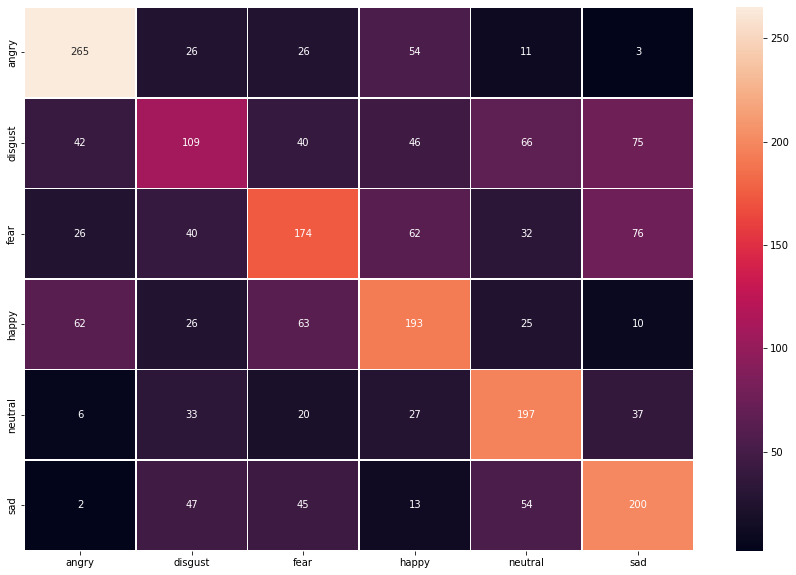

In [ ]:
# most confusing classes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, ax=ax, fmt='g')